In [1]:
import plumed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

from SCRIPTS.func_read import read_fes_3d

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
FOLDER = 'PS-apo/CA_0.85'

In [3]:
BIASF = 5
CV=['cn', 'd_580', 'd_489']

DT=50
kBT=310*8.314462618*0.001

N_walkers = 4
Tminmax = (0.5, 2)
RESI=[489, 580]

REW_COLS = ['ch1_489', 'ch2_489', 'ch1_580', 'ch2_580']
COLS = [*CV, *REW_COLS]

DIHEDRAL_FOLDER = 'DIHEDRAL'
IMAGE_FOLDER='Dihedral_images'

if not os.path.exists(f'{FOLDER}/{IMAGE_FOLDER}'):
    os.mkdir(f'{FOLDER}/{IMAGE_FOLDER}')

# 1. COLVAR with dihedrals
 Create COLVAR with CVs (d_489, d_580, cn) and the values ​​of the dihedral andles χ1 and χ2 from the trajectory at the same time

In [4]:
df_CV = pd.DataFrame()
for w in range(N_walkers):
    cvlr = plumed.read_as_pandas(f'{FOLDER}/walker_{w}/COLVAR.{w}')
    COLVARw = cvlr[(Tminmax[0]*1000**2 <= cvlr['time']) & (cvlr['time'] <= Tminmax[1]*1000**2)]# & (cvlr['time'] < Tmax*1000**2)]
    COLVARw['time'] = COLVARw['time'].astype(int)

    df_full = COLVARw[COLVARw['time']%DT==0]
    for col in REW_COLS: 
        df_col = pd.read_csv(f'{FOLDER}/walker_{w}/{DIHEDRAL_FOLDER}/{col}_gp t_0--1 dt_{DT}.csv', 
                                header = None, names = ['t', col])
        df_col['t'] = df_col['t'].astype(int)

        df_full = df_full.merge(df_col, left_on='time', right_on='t').drop(columns='t')

    df_CV = pd.concat([df_CV, df_full])
    
df_CV.to_csv(f'{FOLDER}/COLVAR_reweighting_{N_walkers}walkers.csv', index = False, sep = '\t')

df_CV

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
/tmp/ipykernel_3597294/3891753273.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cvlr = plumed.read_as_pandas(f'{FOLDER}/walker_{w}/COLVAR.{w}')
/tmp/ipykernel_3597294/3891753273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  COLVARw['time'] = COLVARw['time'].astype(int)
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
/tmp/ipykernel_3597294/3891753273.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated a

,time,d_489,d_580,cn,d_484,d_576,metadP.bias,ch1_489,ch2_489,ch1_580,ch2_580
0,500000,1.773700,1.048590,6.896773,1.900297,1.494457,22.608105,-58.2852,99.5621,-59.5928,105.7960
1,500050,2.147519,1.448714,6.268084,2.189829,1.845960,14.150411,-37.5670,87.3463,-75.6801,82.4799
2,500100,2.234802,1.755538,7.330702,2.264739,2.035705,38.671083,-53.0096,77.1662,-53.1099,158.8040
3,500150,2.497966,1.904153,6.676323,2.492228,2.253595,27.916319,-35.5659,87.0183,-56.5801,92.8528
4,500200,2.655899,2.074677,7.679220,2.692734,2.421489,24.194919,-43.4153,86.5682,-64.2111,118.0750
...,...,...,...,...,...,...,...,...,...,...,...
29996,1999800,1.469828,1.493917,8.067530,1.674883,1.600617,37.541720,-59.8985,-86.2518,-69.2815,-87.7757
29997,1999850,1.542416,1.677570,6.294603,1.815466,1.610840,43.629048,-47.7594,-82.3103,-136.2560,28.9851
29998,1999900,1.733718,1.740161,7.154413,1.948985,1.735823,52.655864,-52.9546,-80.5521,-125.9540,26.8962
29999,1999950,2.032824,2.155727,7.403881,2.345202,2.097780,42.770610,-54.5299,-42.2571,-172.5680,24.3993


# 2. Read Ubias_final

In [5]:
dist1, dist2, cn, fes, Nbins_D1, Nbins_D2, Nbins_CN, Bonds_D1, Bonds_D2, Bonds_CN = read_fes_3d(FOLDER)
fes -= np.max(fes)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
/home/veretenenko/TRPV6-Mg/TRPV6-MG/SCRIPTS/func_read.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = plumed.read_as_pandas(f"{FOLDER}/FES/{NAME}.dat")


240 239 242 [0.0708247, 4.29003] [0.0663656, 4.26809] [0.798874, 9.31687]


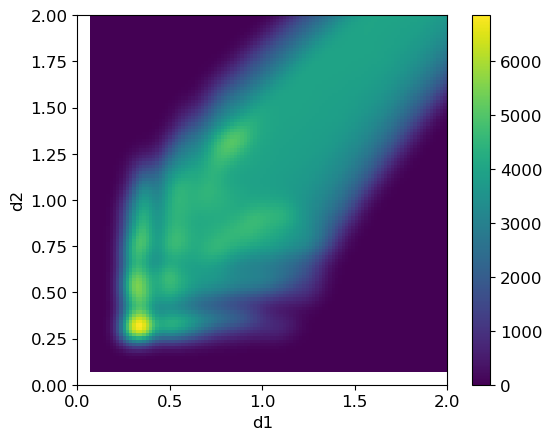

(0.0, 2.0)

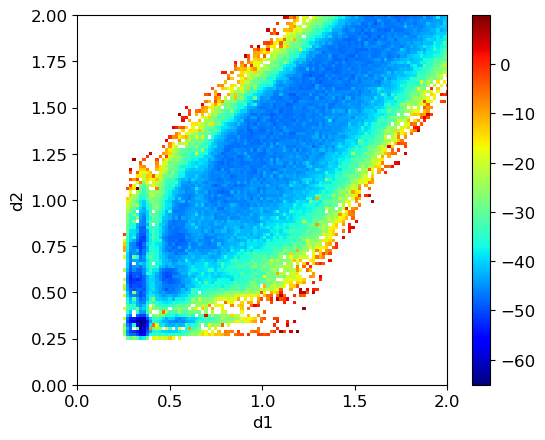

In [6]:
Ubias = -fes * (1-1/BIASF)

WEIGHTS_CV, ED_CV = np.histogramdd(df_CV[['cn', 'd_580', 'd_489']].to_numpy(), 
                            bins = [Nbins_CN, Nbins_D2, Nbins_D1],
                            range = (Bonds_CN, Bonds_D2, Bonds_D1),
                            density=True, 
                            )
h = plt.imshow(np.sum(Ubias, axis=0).T, 
           extent = [ED_CV[2][0], ED_CV[2][-1], ED_CV[1][0], ED_CV[1][-1]],
           aspect='equal',
        origin='lower',
           interpolation=None)
plt.colorbar(h)
plt.xlabel('d1')
plt.ylabel('d2')
plt.title('')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.show()

weighted_avg = np.sum(np.exp(1/kBT * Ubias) * WEIGHTS_CV, axis=0)
weighted_avg[weighted_avg==0]=np.nan
norm = np.sum(np.exp(1/kBT * (Ubias-np.max(Ubias))))
fes_dens = -kBT * np.log(weighted_avg/norm)

h = plt.imshow(fes_dens.T, 
           extent = [ED_CV[2][0], ED_CV[2][-1], ED_CV[1][0], ED_CV[1][-1]],
           aspect='equal',
        origin='lower',
        cmap='jet',
           interpolation=None)
plt.colorbar(h)
plt.xlabel('d1')
plt.ylabel('d2')
plt.title('')
plt.xlim(0, 2)
plt.ylim(0, 2)

# 3. CH1/CH2 reweighting

In [7]:
def func_reweight_2D(CV1, CV2, BINS1, BINS2, RANGE1, RANGE2, emax = None, xlim=None, ylim=None, cmap='terrain'):   
   
    ED_new = [
        np.linspace(*RANGE1, BINS1), 
        np.linspace(*RANGE2, BINS2), 

    ]
    I_cn = np.searchsorted(ED_CV[0], df_CV['cn'], side='left') - 1
    I_d2 = np.searchsorted(ED_CV[1], df_CV['d_580'], side='left') - 1
    I_d1 = np.searchsorted(ED_CV[2], df_CV['d_489'], side='left') - 1

    I_new1 = np.searchsorted(ED_new[0], df_CV[CV1], side='left') - 1
    I_new2 = np.searchsorted(ED_new[1], df_CV[CV2], side='left') - 1

    Ubias = -fes * (1-1/BIASF)
    weight = np.zeros([BINS1, BINS2])
    for t in range(df_CV.shape[0]):
        weight[I_new1[t], I_new2[t]] += np.exp(Ubias[I_cn[t], I_d2[t], I_d1[t]]/kBT)
    weight[weight==0]=np.nan


    fes_dens = -kBT * (np.log(weight))# - scipy.special.logsumexp(weight[~np.isnan(weight)]))
    fes_dens -= np.nanmin(fes_dens)

    fes_dens[np.isnan(fes_dens)] = np.nanmax(fes_dens)
    if emax is None: 
        emax = np.nanmax(fes_dens)//10 * 10
    zi_smoothed = gaussian_filter(fes_dens.reshape([BINS1, BINS2]), sigma=0.5)
    h = plt.contourf(ED_new[0], ED_new[1], zi_smoothed.T, 
                cmap = cmap,
                origin = 'lower',
                aspect = 'equal',
                levels = 15, 
                alpha=0.5,
                )

    plt.colorbar(h, label = 'FES, kJ/mol')

    plt.xlabel(CV1)
    plt.ylabel(CV2)
    plt.title(f'{FOLDER}_{CV1}-{CV2}')
    plt.grid()
    if xlim is None: 
        xlim = RANGE1
    plt.xlim(xlim)
    if ylim is None: 
        ylim = RANGE2
    plt.ylim(ylim)


In [8]:
dens_const = {
    'PS/MG_0.8':5,
    'PS/CA_0.85':2,
    'PS_apo/MG_0.8':5,
    'PS_apo/CA_0.85':1,
}

/tmp/ipykernel_3597294/706068230.py:29: UserWarning: The following kwargs were not used by contour: 'aspect'
  h = plt.contourf(ED_new[0], ED_new[1], zi_smoothed.T,


KeyError: 'PS-apo/CA_0.85'

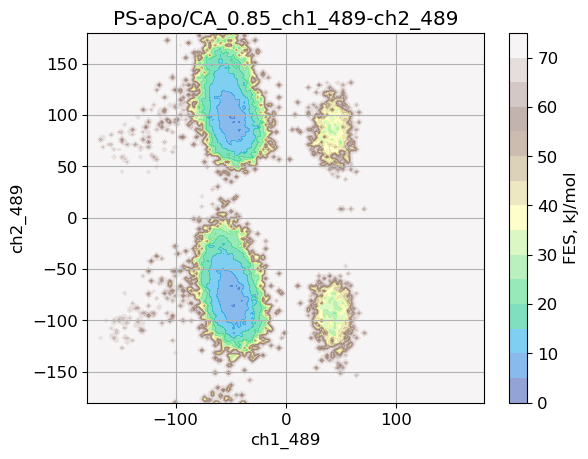

In [9]:
for res in [489, 580]:
    func_reweight_2D(f'ch1_{res}', f'ch2_{res}', 150, 150, [-180, 180], [-180, 180], # 30, 
                    cmap='terrain'
                    )

    df_CV_bind = df_CV[(df_CV[f'd_{res}'] < 0.4) & (df_CV[f'd_{res}']<0.4) ]

    x, y = df_CV_bind[f'ch1_{res}'], df_CV_bind[f'ch2_{res}']

    kde = gaussian_kde(np.vstack([x, y]))
    density = kde(np.vstack([x, y]))

    alpha = 1 / (1 + dens_const[FOLDER] * density / density.max())  # Коэффициенты подберите под ваш случай

    plt.scatter(x, y, c='red', s=20, 
            marker='.', edgecolors='k', linewidth=0.5, rasterized = True)
    plt.xticks([-150, -100, -50, 0, 50, 100, 150])
    plt.yticks([-150, -100, -50, 0, 50, 100, 150])

    plt.title(f'{FOLDER} D{res}')
    plt.xlabel('χ1, ∘')
    plt.ylabel('χ2, ∘')
            
    plt.savefig(f'{FOLDER}/{IMAGE_FOLDER}/ch1_ch2_{res}.svg', bbox_inches = 'tight', dpi=300)
    plt.show()

In [ ]:
! jupyter nbconvert --to notebook Dihedral_angles_reweighting.ipynb --output NOTEBOOKS/Dihedral/$FOLDER
! jupyter nbconvert --to html Dihedral_angles_reweighting.ipynb --output NOTEBOOKS/Dihedral/$FOLDER

[NbConvertApp] Converting notebook Dihedral_angles_reweighting.ipynb to notebook
[NbConvertApp] Writing 569328 bytes to NOTEBOOKS/Dihedral/PS/CA_0.85.ipynb
[NbConvertApp] Converting notebook Dihedral_angles_reweighting.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 876643 bytes to NOTEBOOKS/Dihedral/PS/CA_0.85.html
